In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
# import argparse
import sys
sys.path.append('..')
from models import ResNet18
# from utils import progress_bar

import ipdb
import pickle
import numpy as np
from tqdm import tqdm
import skimage.io as sio

# from tensorboard_logger import Logger
import matplotlib.pyplot as plt

from supervisor.sup_net import SupervisorNetwork

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
# parser.add_argument('--exp_name', type=str, default='checkpoint')
# parser.add_argument('--l1', action='store_true')
# parser.add_argument('--compression', default=0.25, type=float)
# parser.add_argument('--log_after_steps', default=100, type=int)
# parser.add_argument('--lambda_bce', default=1, type=float)
# parser.add_argument('--lambda_ortho', default=1, type=float)
# parser.add_argument('--lambda_quant', default=1, type=float)
# parser.add_argument('--lambda_l1', default=1, type=float)
# parser.add_argument('--switch', nargs='+', type=int, default=[0, 0, 0, 0, 1, 1, 1, 1])
# args = parser.parse_args()

start_epoch = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='/home/gauravm/.torch/', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='/home/gauravm/.torch/', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# logger = Logger(os.path.join('./checkpoint',args.exp_name, 'logs'))

# with open(os.path.join('./checkpoint', args.exp_name, 'args.pkl'), "wb") as f:
#     pickle.dump(args, f)

# Model
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet18()

checkpoint = torch.load('../res/resnet-18-py3.pth')
net.load_state_dict(checkpoint, strict=False)
net.cuda()
net.eval()

path_dims = [64, 64, 128, 128, 256, 256, 512, 512]
switch_vec = [1,1,1,1,1,1,1,1]
print('Switch vector {}'.format(switch_vec))

sup_net = SupervisorNetwork(path_dims)
exp_name = 'sup_all_soft_b1_o0_q1e-1_l1e-1'

models_dir = os.path.join('../checkpoint',exp_name, 'models')

load_epoch = 0
if os.path.exists(models_dir):
    for file in os.listdir(models_dir):
        if file.startswith("sup_net_epoch_"):
            load_epoch = max(load_epoch, int(file.split('_')[3].split('.')[0]))
    if load_epoch > 0:
        load_filename = 'sup_net_epoch_{}.pth'.format(load_epoch)
        print('Loading model {}'.format(load_filename))
        load_path = os.path.join(models_dir, load_filename)
        sup_net.load_state_dict(torch.load(load_path))
else:
    os.makedirs(models_dir)


sup_net.cuda()
sup_net.eval()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
Switch vector [1, 1, 1, 1, 1, 1, 1, 1]
Loading model sup_net_epoch_100.pth


SupervisorNetwork(
  (supervisor_modules): ModuleList(
    (0): SupervisorQuery(
      (class_features): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
      (path_net): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Linear(in_features=256, out_features=64, bias=True)
        (4): Sigmoid()
      )
    )
    (1): SupervisorQuery(
      (class_features): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
      (path_net): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): Batch

In [2]:
def estimate_metrics(pred, random_query, binary_target, sup_net, switch_vec):
    query_pred = torch.gather(pred, 1, random_query.view(-1, 1)).squeeze(1)

    num_s = torch.tensor(np.sum(switch_vec).item(), dtype=torch.float32).to(device)
    # ipdb.set_trace()

    _, class_pred = torch.max(pred, dim=1)
    binary_pred = class_pred.eq(random_query).type(torch.cuda.LongTensor)
    correct = binary_target.eq(binary_pred).sum()
    accuracy = correct.type(torch.cuda.FloatTensor)/binary_target.size(0)

    bce_loss = bce(query_pred, binary_target.type(torch.cuda.FloatTensor))

    metrics = {}
    s_hist = {}
    ortho_mtrx = {}

    metrics['accuracy'] = accuracy
#     metrics['bce_loss'] = bce_loss * args.lambda_bce
    metrics['l1_loss_total'] = torch.from_numpy(np.float32([0.])).to(device)
    metrics['orthogonality_loss_total'] = torch.from_numpy(np.float32([0.])).to(device)
    metrics['quantization_loss_total'] = torch.from_numpy(np.float32([0.])).to(device)
    metrics['total_loss'] = torch.from_numpy(np.float32([0.])).to(device)
    # ipdb.set_trace()
#     metrics['total_loss'] = metrics['total_loss'] + metrics['bce_loss']

    one_hot = torch.zeros((10, 10)).fill_(1).to(device)
    s_one_hot = torch.zeros(10, 10).type(
        torch.cuda.FloatTensor)
    s_queries = torch.from_numpy(np.array(list(range(10)))).to(device)
    s_one_hot = s_one_hot.scatter_(dim=1, index=s_queries.view(-1, 1), src=one_hot)

    s_vectors_all = sup_net(s_one_hot)

    for k in range(len(switch_vec)):
        if switch_vec[k]:
            s_vectors = s_vectors_all[k]
            for i in range(10):
                s_hist['s_layer_{}_class_{}'.format(k, i)] = s_vectors[i].cpu().data.numpy()

            sparsity_loss = l1(s_vectors, torch.zeros_like(s_vectors).to(device))

            orth_loss = torch.from_numpy(np.float32([0.])).to(device)

            for i in range(10):
                for j in range(i,10):
                    orth_loss = orth_loss + torch.dot(s_vectors[i]/torch.norm(s_vectors[i]), s_vectors[j]/torch.norm(s_vectors[j]))

            ortho_mtrx['layer_{}'.format(k)] = np.zeros((10, 10))
            for i in range(10):
                for j in range(10):
                    ortho_mtrx['layer_{}'.format(k)][i][j] = np.dot(s_vectors[i].cpu().data.numpy()/np.linalg.norm(s_vectors[i].cpu().data.numpy()),
                                                                       s_vectors[j].cpu().data.numpy()/np.linalg.norm(s_vectors[j].cpu().data.numpy()))

            quantization_target = s_vectors.detach()>0.5
            quantization_loss = mse(s_vectors, quantization_target.type(torch.cuda.FloatTensor))

            orth_loss = orth_loss/45

            # ipdb.set_trace()
#             metrics['l1_loss_{}'.format(k)] = sparsity_loss * args.lambda_l1
#             metrics['l1_loss_total'] = metrics['l1_loss_total'] + metrics['l1_loss_{}'.format(k)]


#             metrics['orthogonality_loss_{}'.format(k)] = orth_loss * args.lambda_ortho
#             metrics['orthogonality_loss_total'] = metrics['orthogonality_loss_total']  + metrics['orthogonality_loss_{}'.format(k)]

#             metrics['quantization_loss_{}'.format(k)] = quantization_loss * args.lambda_quant
#             metrics['quantization_loss_total'] = metrics['quantization_loss_total'] + metrics['quantization_loss_{}'.format(k)]

    # ipdb.set_trace()

#     metrics['total_loss'] = metrics['total_loss'] + metrics['l1_loss_total']/num_s + \
#                             metrics['orthogonality_loss_total']/num_s + \
#                             metrics['quantization_loss_total']/num_s

    return metrics, s_hist, ortho_mtrx

In [3]:
bce = nn.BCELoss()
l1 = nn.L1Loss()
mse = nn.MSELoss()

epoch = 0
print('\nEpoch: %d Testing' % epoch)
sup_net.eval()

total_metrics = {}
s_hist = {}
ortho_mtrx = {}
hard = False

for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    for c in range(10):

        one_hot = torch.zeros((inputs.size(0), 10)).fill_(1).to(device)

        random_query = torch.zeros(inputs.size(0)).type(torch.LongTensor).fill_(c).to(device)
        random_one_hot = torch.zeros(inputs.size(0), 10).type(
            torch.cuda.FloatTensor)

        random_one_hot = random_one_hot.scatter_(dim=1, index=random_query.view(-1, 1), src=one_hot)
        random_one_hot = random_one_hot.to(device)
        binary_target = targets.eq(random_query).type(torch.cuda.LongTensor)

        imp_vectors = sup_net(random_one_hot)
        if hard:
            imp_vectors = [(imp_vec > 0.5).type(torch.cuda.FloatTensor) for
                           imp_vec in imp_vectors]
        out = net.forward_check_multi(inputs, imp_vectors, switch_vec)
        out_softmax = F.softmax(out, dim=1)

        metrics, s_hist, ortho_mtrx = estimate_metrics(out_softmax, random_query, binary_target, sup_net, switch_vec)

        for name in metrics.keys():
            if name not in total_metrics:
                total_metrics[name] = metrics[name].detach()
            else:
                total_metrics[name] += metrics[name].detach()
    break


Epoch: 0 Testing


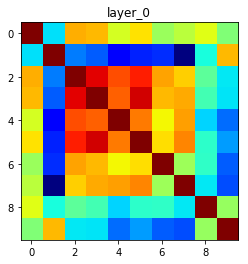

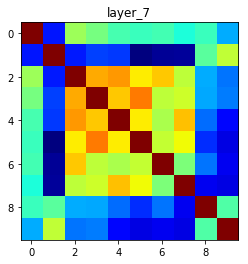

In [5]:
plt.figure()
plt.imshow(ortho_mtrx['layer_4'], cmap='jet')
plt.title('layer_0')
plt.figure()
plt.imshow(ortho_mtrx['layer_7'], cmap='jet')
plt.title('layer_7')

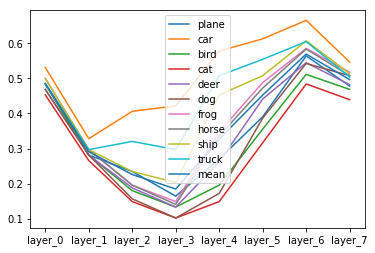

In [6]:
labels = []
plots = np.zeros((10, np.sum(switch_vec)))
count = 0
for k in range(len(switch_vec)):
    if switch_vec[k]:
        labels.append('layer_{}'.format(k))
        for i in range(10):
            plots[i, count] = np.sum(1 - (s_hist['s_layer_{}_class_{}'.format(k, i)]>0.5))/\
                          len(s_hist['s_layer_{}_class_{}'.format(k, i)])
        count += 1
plt.figure()
for i in range(10):
    plt.plot(plots[i], label='{}'.format(classes[i]))
plt.plot(np.mean(plots, axis=0), label='mean')
plt.xticks(np.arange(plots.shape[1]), labels)
plt.legend()